In [1]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import simpy

from requestgen import *

## RPS profiles

rps profiles yield a target average request per second pattern at a given time

the code below runs a simulation for `until` seconds and samples from the rps profile every 0.5 seconds to generate the graph.

In [2]:
def run_rps_profile(env, profile, until, time_step=0.5):
    x = list()
    y = list()

    def generate_profile_data():
        while True:
            rps = next(profile)
            x.append(env.now)
            y.append(rps)
            yield env.timeout(time_step)

    env.process(generate_profile_data())
    env.run(until=until)

    return x,y

### constant profile

does what you'd expect.

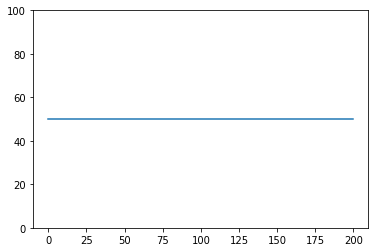

In [3]:
env = simpy.Environment()
profile = constant_rps_profile(50)
t, rps = run_rps_profile(env, profile, 200)
plt.plot(t, rps)
plt.ylim(0,100)
plt.show()

### sine profile

replicates a sine wave with a given peak (max rps) and period (simulation time in seconds between peaks).

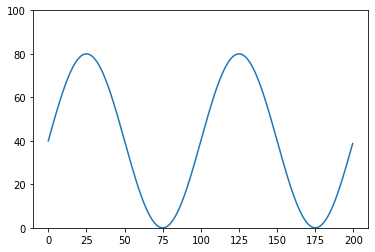

In [4]:
env = simpy.Environment()

profile = sine_rps_profile(env, 80, period=100)

t, rps = run_rps_profile(env, profile, 200)
plt.plot(t, rps)
plt.ylim(0, 100)
plt.show()

### random walk

creates a random walk pattern with
a start rps value (mu),
standard deviation value (sigma), walk will be spikier with higher value,
and max_rps which is the rps cap at where sampled values will be rejected

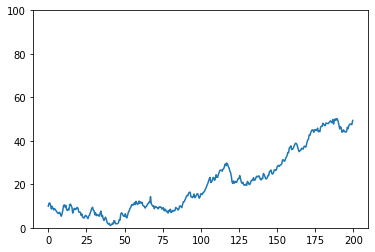

In [5]:
profile = randomwalk_rps_profile(mu=10, sigma=1, max_rps=100)

t, rps = run_rps_profile(simpy.Environment(), profile, 200)
plt.plot(t, rps)
plt.ylim(0, 100)
plt.show()

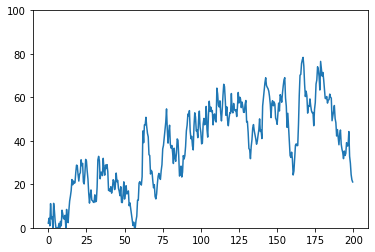

In [6]:
profile = randomwalk_rps_profile(mu=10, sigma=5, max_rps=100)

t, rps = run_rps_profile(simpy.Environment(), profile, 200)
plt.plot(t, rps)
plt.ylim(0, 100)
plt.show()


## Arrival profiles

rps profiles can be decorated using arrival profiles to get a more realistic request pattern.

the code runs a simuluation for `until` simulation seconds, and returns a data frame where each record contains the
current sim time, and the interarrival to the next event.

In [7]:
def run_arrival_profile(env, ia_gen, until):
    x = list()
    y = list()

    def event_generator():
        while True:
            ia = next(ia_gen)
            x.append(env.now)
            y.append(ia)
            yield env.timeout(ia)

    then = time.time()
    env.process(event_generator())
    env.run(until=until)
    print('simulating %d events took %.2f sec' % (len(x), time.time() - then))

    df = pd.DataFrame(data = {'simtime': x, 'ia': y}, index=pd.DatetimeIndex(pd.to_datetime(x,unit='s',origin='unix')))
    return df

simulating 71770 events took 0.17 sec


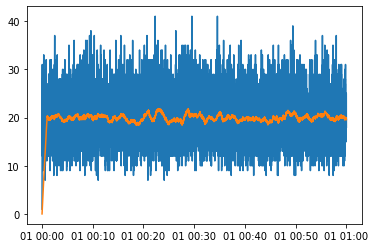

In [8]:
profile = expovariate_arrival_profile(constant_rps_profile(rps=20))
df = run_arrival_profile(simpy.Environment(), profile, until=3600)

x1 = df['ia'].rolling('1s').count()
x2 = df['ia'].rolling('60s').count() / 60

plt.plot(x1)
plt.plot(x2)
plt.show()


### with varying rps

with some rps profiles that can reach 0 rps, it is necessary to use a `max_ia` value to guard against `rps==0`
(where `ia = 1/rps` and would otherwise lead to math errors).
The `max_ia` is, in other words, the longest possible gap between events (e.g., 120 seconds).

simulating 37010 events took 0.10 sec


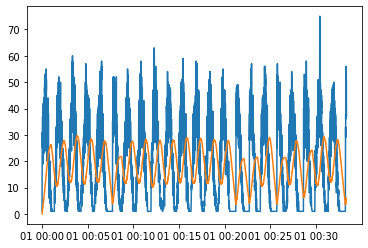

In [9]:
env = simpy.Environment()
profile = expovariate_arrival_profile(sine_rps_profile(env, max_rps=40, period=90), max_ia=35)
df = run_arrival_profile(env, profile, until=2000)

x1 = df['ia'].rolling('1s').count()
x2 = df['ia'].rolling('60s').count() / 60

plt.plot(x1)
plt.plot(x2)
plt.show()

simulating 99718 events took 0.24 sec


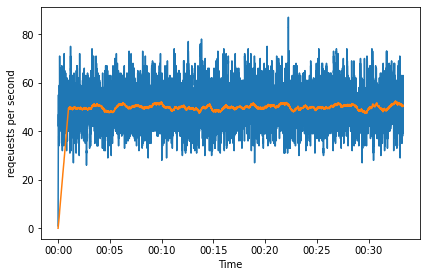

In [10]:
import matplotlib.dates as dates
fig, axs = plt.subplots(1,1, figsize=(6.8,4.27))
env = simpy.Environment()
profile = expovariate_arrival_profile(constant_rps_profile(50))
df = run_arrival_profile(env, profile, until=2000)

x1 = df['ia'].rolling('1s').count()
x2 = df['ia'].rolling('60s').count() / 60

plt.plot(x1)
plt.plot(x2)
plt.gca().xaxis.set_major_locator(dates.MinuteLocator(byminute=[0,5,10,15,20,25,30,45], interval = 1))
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
plt.ylabel('reqeuests per second')
plt.xlabel('Time')
plt.show()

simulating 112418 events took 0.30 sec


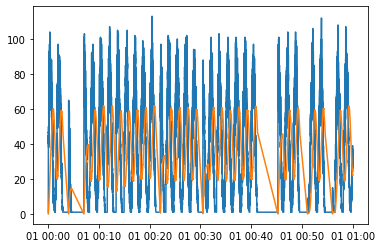

In [11]:
env = simpy.Environment()
profile = expovariate_arrival_profile(sine_rps_profile(env, 80, period=100),max_ia=240)
df = run_arrival_profile(env, profile, until=3600)

x1 = df['ia'].rolling('1s').count()
x2 = df['ia'].rolling('60s').count() / 60

plt.plot(x1)
plt.plot(x2)
plt.show()

# Save and replay profile

In the first step you create a profile with profile generator helper functions.
You can either create your own Environment instance or let `save_requests` generate a default simpy Environment.

In [12]:
profile = lambda env: expovariate_arrival_profile(sine_rps_profile(env, 80, period=100),max_ia=240)
file = '/tmp/exp_profile.pkl'
save_requests(profile, duration=100, file=file)
with open(file, 'rb') as fd:
    print(pickle.load(fd)[:5])

simulating 3809 events took 0.01 sec
[0.012037827605670475, 0.026044858173768164, 0.0027674766717902025, 0.023227522098120363, 0.12558687142650002]


Afterwards, use `pre_recorded_profile` as interarrival generator.

simulating 3809 events took 0.01 sec


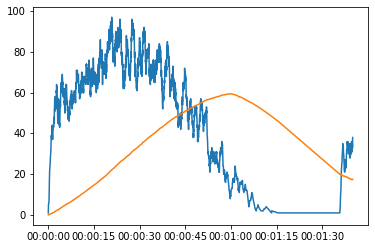

In [13]:
profile = pre_recorded_profile(file)
df = run_arrival_profile(simpy.Environment(), profile, until=100)

x1 = df['ia'].rolling('1s').count()
x2 = df['ia'].rolling('60s').count() / 60

plt.plot(x1)
plt.plot(x2)
plt.show()

# Concatenating multiple profiles

Define a list of profiles, each associated with the duration of running.
Calling `concatenate_profiles_and_save` concatenates the profiles and saves the resulting profile as a pickle.

In [14]:
profile_1 = lambda env: expovariate_arrival_profile(sine_rps_profile(env, 80, period=100),max_ia=20)
duration_profile_1 = 200
profile_2 = lambda env: expovariate_arrival_profile(constant_rps_profile(80),max_ia=20)
duration_profile_2 = 200
profiles = [(profile_1, duration_profile_1), (profile_2, duration_profile_2)]
concatenate_profiles_and_save('test.pkl', profiles)

simulating 7850 events took 0.02 sec
simulating 16038 events took 0.06 sec


Afterwards, we can read the previously saved profile and plot it.

simulating 23886 events took 0.04 sec


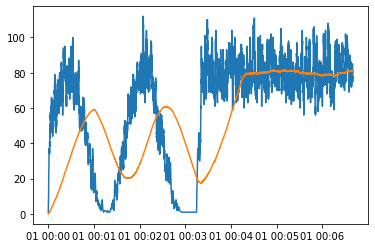

In [15]:
profile = pre_recorded_profile('test.pkl')
df = run_arrival_profile(simpy.Environment(), profile, until=400)

x1 = df['ia'].rolling('1s').count()
x2 = df['ia'].rolling('60s').count() / 60

plt.plot(x1)
plt.plot(x2)
plt.show()